# [WK] Projekt 1 - Opis obrazu
#### Autorzy: Agnieszka Klimek (145302), Anna Prałat (145395), Daniel Zdancewicz (145317)

## Opis zadania
Śledzenie gry w bilard.
Dla filmów przedstawiających grę w bilard (dowolna odmiana) zaproponuj system:
- Wykrywania bili
- Śledzenia bili
- Wykrywania zdarzeń na filmie
Należy samodzielnie przygotować odpowiednie dane wejściowe.

## Założenia
Jako przyjętą reprezentację obrazu przyjęto filmy gry w snookera z perspektywy ptaka (bird view).
Założono, że kamera jest nieruchoma, a stół do gry jest prostokątem. DOdatkowo założono, że
kamera jest umieszczona nad środkiem stołu, a kąt nachylenia kamery jest równy 90 stopni.

Jako zdarzenia, które są wykrywane na filmie:
- Wbicie bili do łuzy
- Zderzenie bili z drugą bilą


## Technika wykrywania bil na obrazie

1. Wczytanie obrazu
2. Przekształcenie obrazu do skali szarości
3. ???
4. Rozpoznanie 7 masek (po jednej dla każdego koloru bili)
5. Rozpoznanie konturów bili
6. Zapis pozycji zawierających kontury w kolejnych klatkach filmu
7. Zastosowanie prostych równań fizycznych na podstawie pozycji do wyznaczenia pozycji bili w kolejnych klatkach filmu
8. Wykrywanie zdarzeń na podstawie momentum kuli


# Importy

In [2]:
import matplotlib
import PIL
from cv2 import VideoCapture, CAP_PROP_FPS
import cv2
from typing import Iterable
import numpy as np
from numpy import uint8 as u8, int8 as i8
from numpy.typing import NDArray
from dataclasses import dataclass, field
from random import choice
from copy import deepcopy
from sklearn.cluster import KMeans
from skimage.morphology import disk

## Klasy pomocnicze

In [3]:
class Kernel(object):
  @staticmethod
  def sobel_horizontal() -> NDArray[u8]:
    return np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=i8)

  @staticmethod
  def sobel_vertical() -> NDArray[u8]:
    return np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=i8)


In [4]:
def exhaust(iterable: Iterable):
  for _ in iterable: ...


def repeat(value):
  while True: yield value

In [5]:
def imshow(*images):
  try:
    for contents in images:
      if not isinstance(contents, np.ndarray) and isinstance(contents, Iterable):
        imshow(*contents)

    images = [np.array(image).clip(0, 255).astype(u8) for image in images]
    for (i, image) in enumerate(images):
      if image.ndim == 2: images[i] = np.stack([image, image, image], axis=2)
    images = np.concatenate(images, axis=1)

    if images.ndim == 3:
      if images.shape[2] == 4:
        images = cv2.cvtColor(images, cv2.COLOR_BGRA2RGBA)
      else:
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(images))
  except Exception:
    pass


In [6]:
@dataclass
class Hsv(object):
  h: int
  s: int
  v: int
  name: str | None = None


class BallColor(object):
  @staticmethod
  def similarity(image: NDArray[u8], color_range: tuple[Hsv, Hsv]) -> Hsv:
    (lower, upper) = color_range
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    return cv2.inRange(hsv, np.array([lower.h, lower.s, lower.v]), np.array([upper.h, upper.s, upper.v]))

  @classmethod
  def similarity_rate(cls, image: NDArray[u8], color_range: tuple[Hsv, Hsv]) -> float:
    return np.mean(cls.similarity(image, color_range) - cls.similarity(image, BallColor.backdrop_range))

  @classmethod
  def most_similar(cls, image: NDArray[u8]) -> str:
    return max(cls.colors, key=lambda x: cls.similarity_rate(image, x))[0].name

  @classmethod
  def most_similars(cls, images: Iterable[NDArray[u8]]) -> list[str]:
    return tuple(map(cls.most_similar, images))

  black_range = (Hsv(0, 0, 0, "black"), Hsv(180, 255, 100, "black"))
  white_range = (Hsv(0, 0, 250, "white"), Hsv(180, 255, 255, "white"))
  brown_range = (Hsv(10, 200, 100, 'brown'), Hsv(35, 250, 150, 'brown'))
  yellow_range = (Hsv(30, 100, 100, "yellow"), Hsv(35, 255, 255, "yellow"))
  blue_range = (Hsv(75, 100, 100, 'blue'), Hsv(100, 255, 255, 'blue'))
  green_range = (Hsv(60, 100, 100, 'green'), Hsv(75, 255, 175, 'green'))
  red_range = (Hsv(0, 150, 100, 'red'), Hsv(20, 255, 255, 'red'))
  pink_range = (Hsv(0, 110, 100, 'pink'), Hsv(20, 200, 255, 'pink'))
  backdrop_range = (Hsv(45, 100, 100, 'red'), Hsv(60, 255, 255, 'red'))


BallColor.colors = [
  BallColor.black_range,
  BallColor.white_range,
  BallColor.yellow_range,
  BallColor.blue_range,
  BallColor.green_range,
  BallColor.pink_range,
  BallColor.brown_range,
  BallColor.red_range,
]


In [7]:
@dataclass
class VideoInfo(object):
  fps: float
  width: int
  height: int
  dtype: type
  frames: list[NDArray[u8]] = field(default_factory=list)

  def __len__(self):
    return len(self.frames)

  @classmethod
  def from_video(cls, video: VideoCapture):
    width = int(video.get(3))
    height = int(video.get(4))
    fps = video.get(CAP_PROP_FPS)
    frames = []
    while True:
      success, frame = video.read()
      if not success: break
      frames.append(frame)
    video.release()

    dtype = len(frames) > 0 and frames[0].dtype or None
    return cls(fps, width, height, dtype, frames)

  def sample(self):
    return deepcopy(choice(self.frames))

  def __getitem__(self, index):
    if isinstance(index, slice):
      return deepcopy(self.frames[index.start:index.stop:index.step])
    return deepcopy(self.frames[index])


In [8]:
class TransformContext(object):
  def __init__(self, image: NDArray[u8]):
    self.image = image.copy()

  def grayscale(self):
    self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
    return self

  def threshold(self, under: int | None = None, over: int | None = None):
    if under is not None: self.image[self.image < under] = 0
    if over is not None: self.image[self.image > over] = 0
    return self

  def threshold_adaptive(self, size: int, c: int):
    self.image = cv2.adaptiveThreshold(self.image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, size, c)
    return self

  def clip_edges(self, size: int):
    self.image[:size, :] = 0
    self.image[-size:, :] = 0
    self.image[:, :size] = 0
    self.image[:, -size:] = 0
    return self

  def dilate(self, kernel: NDArray[i8], iterations: int = 1):
    self.image = cv2.dilate(self.image, kernel, iterations=iterations)
    return self

  def erode(self, kernel: NDArray[i8], iterations: int = 1):
    self.image = cv2.erode(self.image, kernel, iterations=iterations)
    return self

  def opening(self, kernel: NDArray[i8], iterations: int = 1):
    self.image = cv2.morphologyEx(self.image, cv2.MORPH_OPEN, kernel, iterations=iterations)
    return self

  def closing(self, kernel: NDArray[i8], iterations: int = 1):
    self.image = cv2.morphologyEx(self.image, cv2.MORPH_CLOSE, kernel, iterations=iterations)
    return self

  def proper_opening(self, kernel: NDArray[i8]):
    intermediate = cv2.morphologyEx(self.image, cv2.MORPH_OPEN, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_CLOSE, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_OPEN, kernel)
    self.image = np.maximum(self.image, intermediate)
    return self

  def proper_closing(self, kernel: NDArray[i8]):
    intermediate = cv2.morphologyEx(self.image, cv2.MORPH_CLOSE, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_OPEN, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_CLOSE, kernel)
    self.image = np.minimum(self.image, intermediate)
    return self

  def automedian(self, kernel: NDArray[i8]):
    intermediate = cv2.morphologyEx(self.image, cv2.MORPH_OPEN, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_CLOSE, kernel)
    intermediate = cv2.morphologyEx(intermediate, cv2.MORPH_OPEN, kernel)
    self.image = np.maximum(intermediate, self.proper_closing(kernel).consume())
    return self

  def mask(self, mask: NDArray[u8], inverse: bool = False):
    mask = mask.copy()
    if inverse: mask = cv2.bitwise_not(mask)
    if len(mask.shape) == 2: mask = np.expand_dims(mask, axis=2)
    self.image = cv2.bitwise_and(self.image, mask)
    return self

  def masks(self, masks: Iterable[NDArray[u8]], inverse: bool = False):
    for mask in masks: self.mask(mask, inverse)
    return self

  def clipped(self, box: tuple[int, int, int]):
    x, y, r = box
    return self.image[y - r:y + r, x - r:x + r]

  def consume(self):
    return self.image.copy()


In [9]:

class Detection(object):
  @staticmethod
  def disks(image: NDArray[u8], min_distance: int = 1) -> NDArray[tuple[int, int, int]]:
    coordinates = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, min_distance, param1=100, param2=10, minRadius=8,
                                   maxRadius=16)
    if coordinates is None: coordinates = np.array([[]])
    return np.uint16(np.around(coordinates))[0]

  @staticmethod
  def edges(image: NDArray[u8]) -> NDArray[tuple[int, int]]:
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold = cv2.adaptiveThreshold(grayscale, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, -12)
    lines = cv2.HoughLinesP(threshold, rho=2, theta=np.pi / 20, threshold=600, minLineLength=400, maxLineGap=50)
    lines = lines.squeeze(axis=1)
    return lines

  @staticmethod
  def intersections(edges: NDArray[tuple[int, int]], tolerance: float = 0.1) -> list[tuple[int, int]]:
    def find_intersection(line1, line2):
      xd = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
      yd = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

      def determinant(a, b):
        return a[0] * b[1] - a[1] * b[0]

      det = determinant(xd, yd)
      if det == 0: return None

      d = (determinant(*line1), determinant(*line2))
      x = int(determinant(d, xd) / det)
      y = int(determinant(d, yd) / det)
      return x, y

    intersections = []
    for (x1, y1, x2, y2) in edges:
      for (x3, y3, x4, y4) in edges:
        m1 = abs((y2 - y1) / (x2 - x1))
        m2 = abs((y4 - y3) / (x4 - x3))
        if abs(m1 - m2) > tolerance:
          intersection = find_intersection(((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)))
          if intersection is None: continue
          intersections.append(intersection)
    return intersections

  @staticmethod
  def corners(intersections: Iterable[tuple[int, int]], count: int) -> NDArray[tuple[int, int]]:
    intersections = deepcopy(intersections)
    for intersection in intersections:
      _, y = intersection
      if y < 10: intersections.remove(intersection)

    intersections = np.asarray(intersections).astype(np.float32)
    model = KMeans(n_clusters=count, n_init=10)
    model.fit(intersections)
    segments = model.predict(intersections)
    corners = np.stack([intersections[segments == i].mean(0) for i in range(count)], 0)

    return corners.astype(int)

  @staticmethod
  def borders(corners: NDArray[tuple[int, int]], tolerance: int = 2) -> NDArray[tuple[int, int]]:
    borders = []
    for first in corners:
      for second in corners:
        if any(first != second) and (
            abs(first[0] - second[0]) < tolerance or abs(first[1] - second[1]) < tolerance):
          borders.append((first, second))

    return np.array(borders)

  @staticmethod
  def oversized(image: NDArray[u8], size: int = 4200) -> Iterable[NDArray[u8]]:
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    oversized = []
    for contour in contours:
      if cv2.contourArea(contour) <= size: continue
      mask = np.zeros(image.shape[:2])
      mask = cv2.drawContours(mask.copy(), [contour], -1, (255, 0, 0), -1)
      oversized.append(TransformContext(mask).dilate(kernel, 2).closing(kernel).consume().astype(u8))
    return oversized


In [10]:
class DrawContext(object):
  def __init__(self, image: NDArray[u8], coordinates: Iterable[tuple[int, int, int]] = None):
    self.image = image.copy()
    self.coordinates = coordinates
    if self.coordinates is None: self.coordinates = []

  def points(self, coordinates: Iterable[tuple[int, int, int]] = None):
    coordinates = coordinates if coordinates is not None else self.coordinates
    for (x, y, _) in coordinates:
      cv2.circle(self.image, (x, y), 4, (255, 0, 0), -1)
    return self

  def boxes(self, coordinates: Iterable[tuple[int, int, int]] = None):
    coordinates = coordinates if coordinates is not None else self.coordinates
    for (x, y, z) in coordinates:
      cv2.rectangle(self.image, (x - 16, y - 16), (x + 16, y + 16), (255, 0, 0), 2)
    return self

  def disks(self, coordinates: Iterable[tuple[int, int, int]] = None):
    coordinates = coordinates if coordinates is not None else self.coordinates
    for (x, y, z) in coordinates:
      cv2.circle(self.image, (x, y), z, (0, 0, 255), -1, cv2.LINE_AA)
    return self

  def circle(self, coordinate: tuple[int, int], size: int):
    (x, y) = coordinate
    cv2.circle(self.image, (x, y), size, (0, 0, 255), 2, cv2.LINE_AA)
    return self

  def lines(self, lines: NDArray[tuple[int, int]], size=5):
    for first, second in lines:
      cv2.line(self.image, first, second, (255, 0, 0), size, cv2.LINE_AA)
    return self

  def label(self, label: str, at: tuple[int, int, int]):
    (x, y, z) = at
    (label_x, label_y) = cv2.getTextSize(label, 5, 1, 1)[0]
    label_x = x - label_x // 2
    label_y = y + label_y // 2

    cv2.putText(self.image, label, (label_x, label_y + z + 5), 5, 1, (255, 235, 255), 1, cv2.LINE_AA)
    return self

  def labels(self, labels: list[str], at: list[tuple[int, int, int]]):
    exhaust(map(self.label, labels, at))
    return self

  def consume(self):
    return self.image.copy()


## Wczytanie filmu

In [11]:
match = VideoCapture('resources/matches/match-1-topdown-view.mp4')

video = VideoInfo.from_video(match)

## Prezentacja parametrów filmu


Video info:
  FPS    : 25.0
  Width  : 1280
  Height : 720
  Frame  : 3245
  d-type : uint8



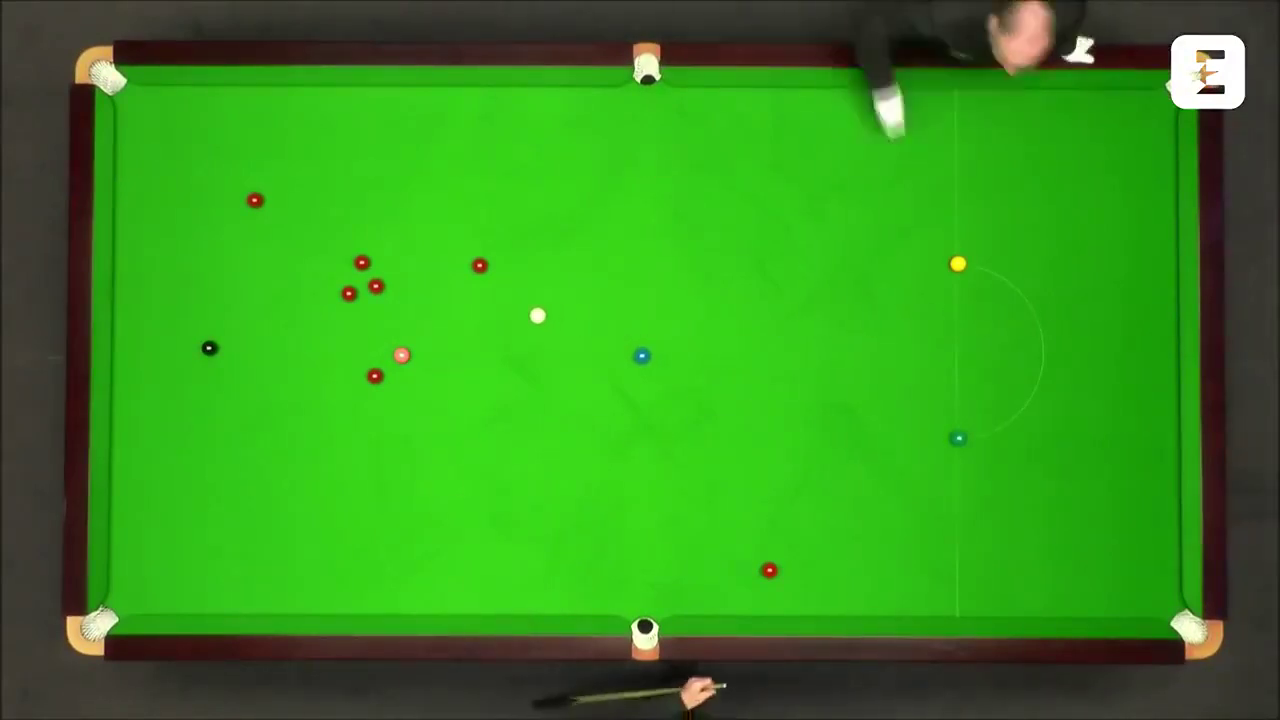

In [12]:
print(f"""
Video info:
  FPS    : {video.fps}
  Width  : {video.width}
  Height : {video.height}
  Frame  : {len(video)}
  d-type : {video.dtype}
""")

imshow(video.sample())

## Wykrywanie krawędzi stołu

In [13]:
def fft(image: NDArray[u8], size: Iterable[int] | None = None) -> tuple[NDArray[u8], int]:
  frequencies = np.fft.fft2(image, size)
  shift = np.fft.fftshift(frequencies)
  spectrum = 20 * np.log(np.abs(shift))
  return shift, spectrum


def ifft(shift: NDArray[u8]) -> NDArray[u8]:
  inverse = np.fft.ifftshift(shift)
  image = np.fft.ifft2(inverse)
  return np.real(image)


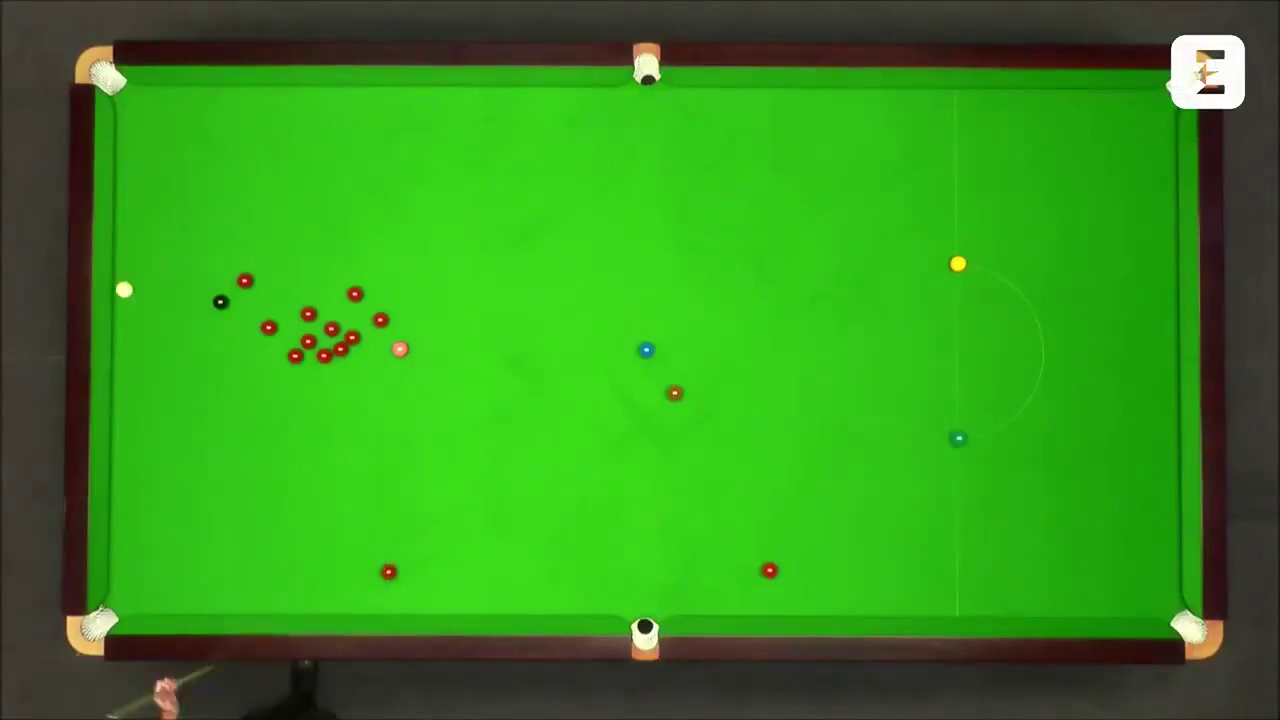

In [14]:
image = video.frames[50]

imshow(image)

In [15]:
def create_table_mask(image: NDArray[u8], corners: NDArray[tuple[int, int]]):
  def sorted_corners():
    sums = {
      i: x + y
      for i, (x, y) in enumerate(corners)
    }

    sums = sorted(sums.items(), key=lambda x: x[1])
    items = np.array([corners[s[0]] for s in sums])

    items[3], items[2] = items[2].copy(), items[3].copy()
    return items

  grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  threshold = cv2.adaptiveThreshold(grayscale, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, -12)
  table_mask = cv2.fillConvexPoly(np.zeros_like(threshold) + 255, sorted_corners(), 1)

  # apply extra 10 pixels inset
  table_mask = cv2.dilate(table_mask, np.ones((60, 30), np.uint8), iterations=1)
  num_rows, num_cols = table_mask.shape[:2]
  table_mask = 255 - table_mask
  translation_matrix = np.float32([[1, 0, 0], [0, 1, 0]])
  table_mask = cv2.warpAffine(table_mask, translation_matrix, (num_cols, num_rows))
  table_mask = 255 - table_mask
  return table_mask


## Obróbka obrazu do wykrywania bili

In [16]:
def magnify_objects(image: NDArray[u8], table_mask: NDArray[u8]) -> NDArray[u8]:
  grayscale = TransformContext(image).grayscale().consume()
  vertical_kernel = Kernel.sobel_vertical()
  horizontal_kernel = Kernel.sobel_horizontal()

  shift, _ = fft(grayscale)
  vertical_shift, _ = fft(vertical_kernel, image.shape[:2])
  horizontal_shift, _ = fft(horizontal_kernel, image.shape[:2])

  vertical = ifft(shift * vertical_shift)
  horizontal = ifft(shift * horizontal_shift)

  return (TransformContext(np.sqrt(vertical ** 2 + horizontal ** 2).astype(u8))
          .dilate(np.ones((3, 3)), 2)
          .erode(np.ones((3, 3)), 1)
          .threshold(50)
          .proper_opening(np.ones((16, 16)))
          .automedian(np.ones((3, 3)))
          .mask(table_mask, True)
          .consume())


## Przedstawienie transformacji dokonywanych na klatkach filmu

/tmp/ipykernel_31288/3385821495.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  m2 = abs((y4 - y3) / (x4 - x3))
/tmp/ipykernel_31288/3385821495.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  m1 = abs((y2 - y1) / (x2 - x1))
/tmp/ipykernel_31288/3385821495.py:39: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(m1 - m2) > tolerance:
/tmp/ipykernel_31288/15401090.py:4: RuntimeWarning: divide by zero encountered in log
  spectrum = 20 * np.log(np.abs(shift))


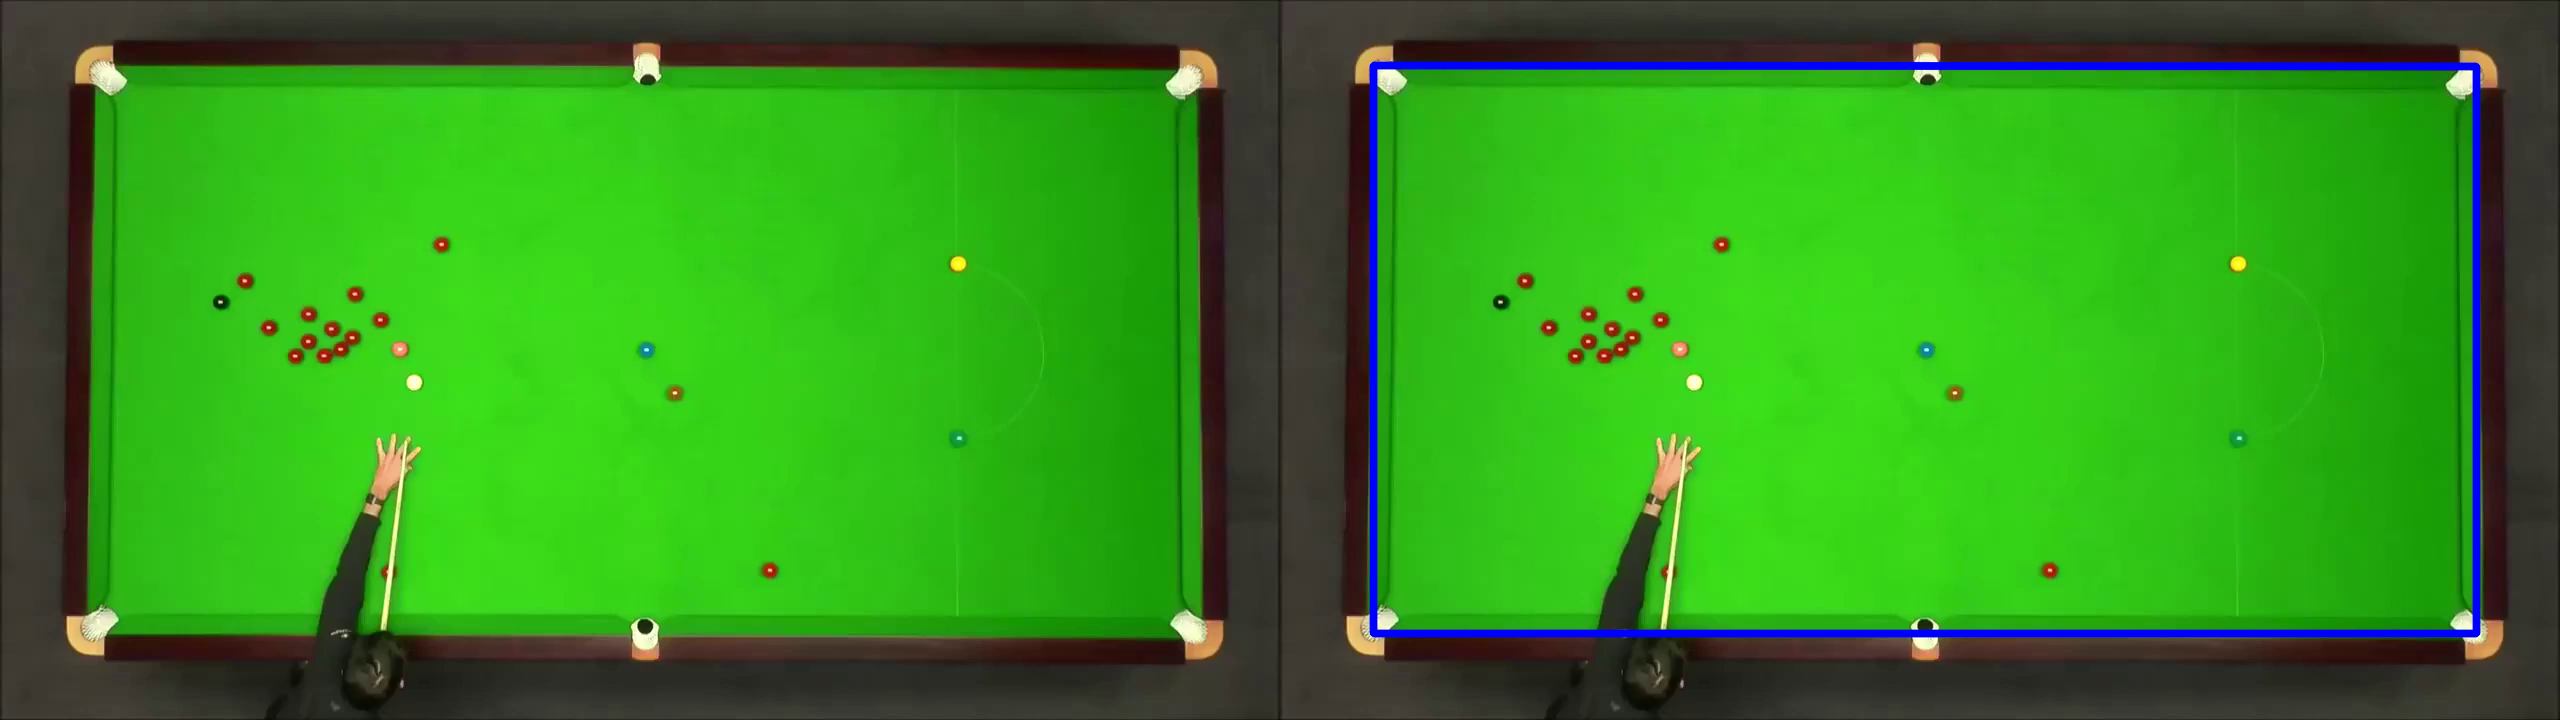

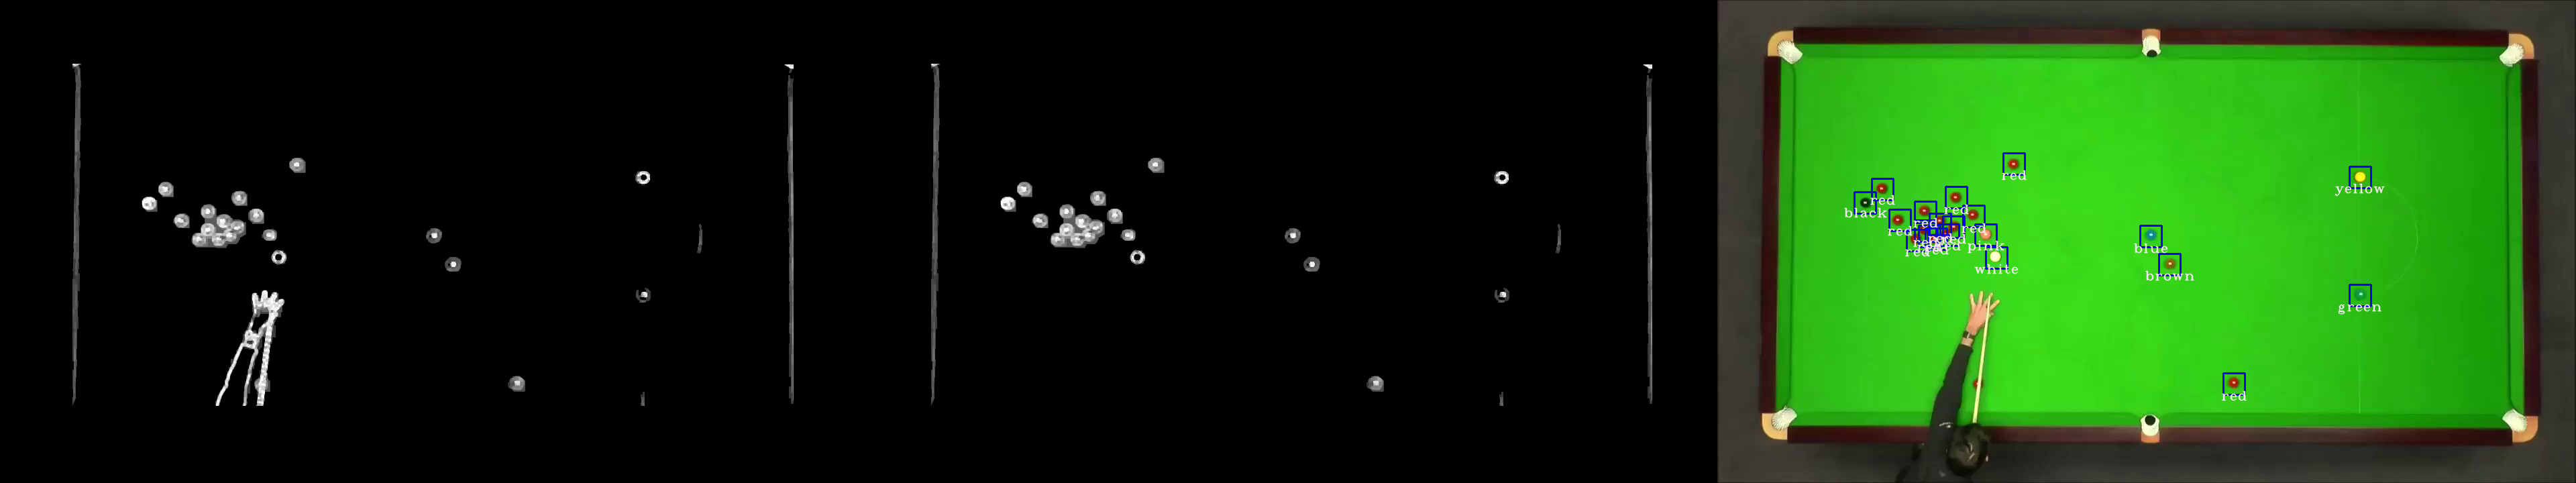

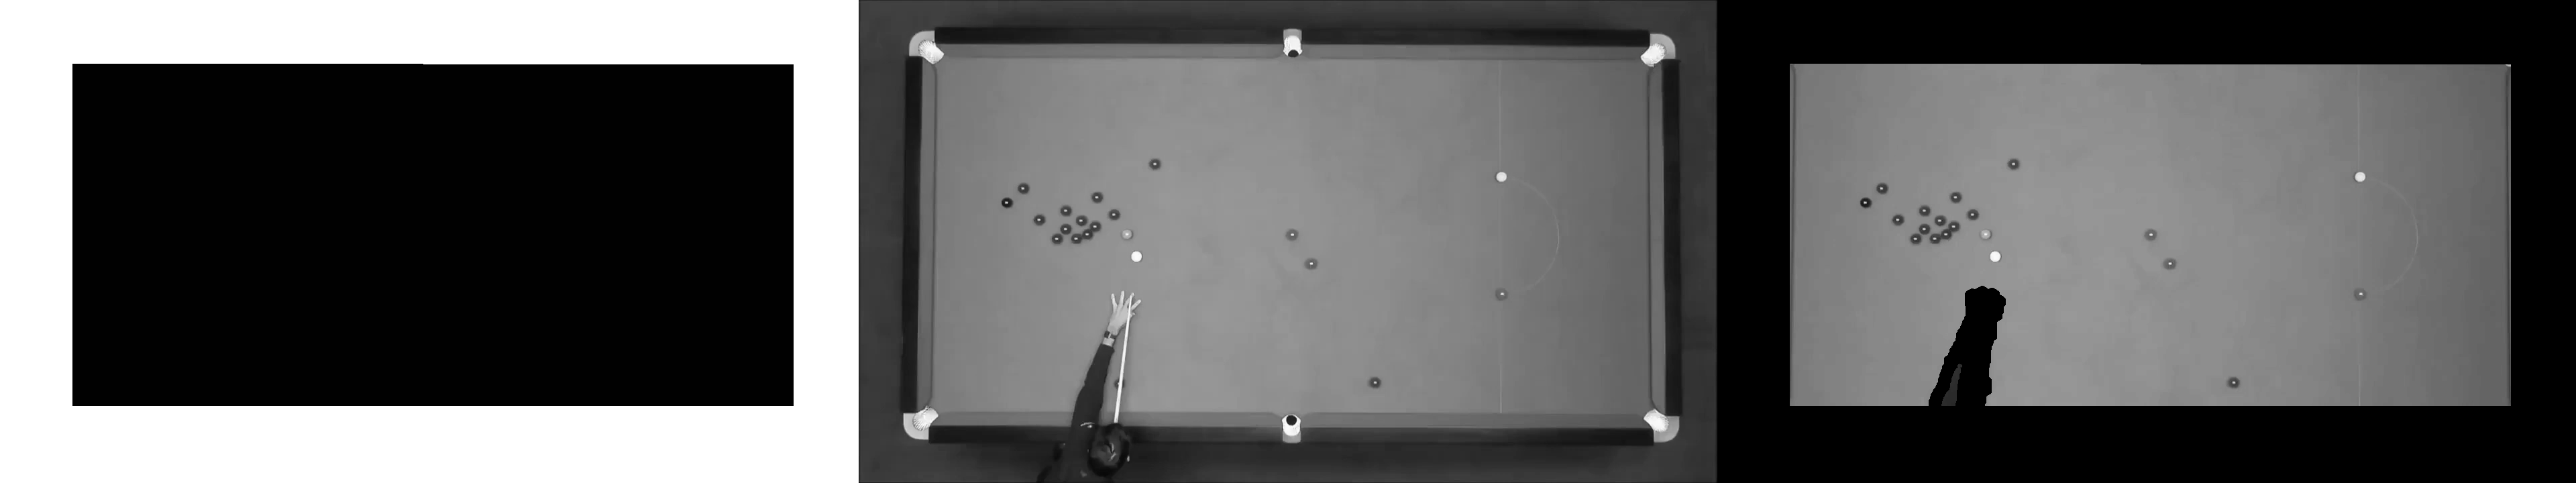

In [17]:
image = video[0]
edges = Detection.edges(image)
intersections = Detection.intersections(edges, tolerance=0.1)
corners = Detection.corners(intersections, 4)
borders = Detection.borders(corners)

table_mask = create_table_mask(image, corners)
magnified = magnify_objects(image, table_mask)
masks = Detection.oversized(magnified, 4500)

context = TransformContext(magnified)
for mask in masks: context.mask(mask, inverse=True)
cleared = context.consume()
coordinates = Detection.disks(cleared, 10)

labels = BallColor.most_similars(map(TransformContext(image).clipped, coordinates))
labeled = DrawContext(image).boxes(coordinates).labels(labels, coordinates).consume()

imshow(
  [image, DrawContext(image).lines(borders).consume()],
  [magnified, cleared, labeled],
  [
    table_mask,
    grayscale := TransformContext(image).grayscale().consume(),
    TransformContext(grayscale).mask(table_mask, inverse=True).mask(mask, inverse=True).consume()
  ]
)

## Przygotowanie klatek do wykrywania bili

In [19]:
@dataclass
class FrameInfo(object):
  annotations: Iterable[tuple[str, tuple[int, int, int], NDArray[u8]]]
  mask: NDArray[u8]
  image: NDArray[u8]


class Tracker(object):
  def __init__(self, video: VideoInfo):
    self.table_mask: NDArray[u8] = None
    self.video = video
    self.i = -1

  def __iter__(self):
    return self

  def __next__(self):
    self.i += 1
    return self.prepare()

  def prepare(self):
    frame = self.video[self.i]
    print(self.i)
    if self.table_mask is None:
      edges = Detection.edges(frame)
      intersections = Detection.intersections(edges, tolerance=0.1)
      corners = Detection.corners(intersections, 4)

      self.table_mask = create_table_mask(frame, corners)

    magnified = magnify_objects(frame, self.table_mask)

    context = TransformContext(magnified)
    for mask in Detection.oversized(magnified, 3500):
      context.mask(mask, inverse=True)
    mask = context.consume()
    coordinates = Detection.disks(mask, 10)

    clips = tuple(map(TransformContext(frame).clipped, coordinates))
    labels = BallColor.most_similars(clips)

    return FrameInfo(
      tuple(zip(labels, coordinates, clips)),
      mask,
      frame
    )


class FrameInfoMethods(object):
  @staticmethod
  def draw(frame: FrameInfo):
    labels, coordinates, _ = zip(*frame.annotations)

    return DrawContext(frame.image).boxes(coordinates).labels(labels, coordinates).consume()

  @staticmethod
  def find(frame: FrameInfo, color: str):
    if frame.annotations is None: return []
    matching = tuple(filter(lambda x: x[0] == color, frame.annotations))
    print(len(matching))


In [21]:
@dataclass
class BallPositions(object):
  red: Iterable[tuple[int, int]] = field(default_factory=list)
  yellow: tuple[int, int] | None = None
  green: tuple[int, int] | None = None
  brown: tuple[int, int] | None = None
  blue: tuple[int, int] | None = None
  pink: tuple[int, int] | None = None
  black: tuple[int, int] | None = None
  white: tuple[int, int] | None = None


@dataclass
class MatchMemory(object):
  positions: BallPositions = field(default_factory=BallPositions)



In [22]:
import itertools


def take(it, count):
  return tuple(itertools.islice(it, count))


tracker = iter(Tracker(video))
frames = take(tracker, 500)

0


/tmp/ipykernel_31288/3385821495.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  m2 = abs((y4 - y3) / (x4 - x3))
/tmp/ipykernel_31288/3385821495.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  m1 = abs((y2 - y1) / (x2 - x1))
/tmp/ipykernel_31288/3385821495.py:39: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(m1 - m2) > tolerance:
/tmp/ipykernel_31288/15401090.py:4: RuntimeWarning: divide by zero encountered in log
  spectrum = 20 * np.log(np.abs(shift))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


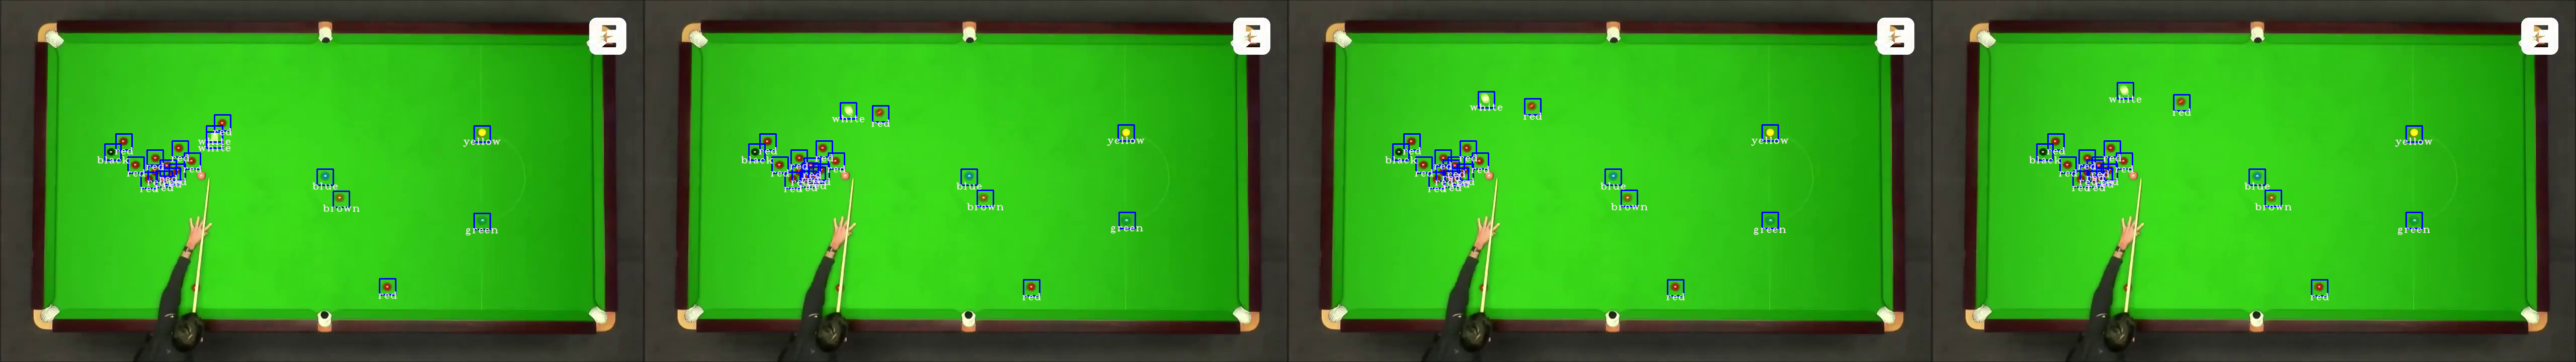

2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
2 dict_keys(['red', 'pink'])
1 dict_keys(['red'])
1 dict_keys(['red'])
1 dict_keys(['red'])
1 dict_keys(['red'])
0 dict_keys([])
0 dict_keys([])
0 dict_keys([])
0 dict_keys([])
0 dict_keys([])
0 dict_keys([])
0 dict_keys([])
0 dict_keys([])
0 dict_keys([])
0 dict_keys([])
0 

In [94]:
from collections import defaultdict
from itertools import pairwise

imshow(*map(lambda x: FrameInfoMethods.draw(x), frames[28:32]))


def track(frames: Iterable[FrameInfo], color: str) -> Iterable[tuple[int, int]]:
  def calculate_distance(a: tuple[int, int, int], b: tuple[int, int, int]):
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

  history = []
  for i, frame in enumerate(frames):
    candidates = tuple(filter(lambda x: x[0] == color, frame.annotations))

    if not candidates and history:
      candidate = history[-1]
    elif len(candidates) > 1:
      candidates = [min(candidates, key=lambda m: calculate_distance(history[-1], m[1]))]
      candidate = candidates[0][1]
    else:
      candidate = candidates[0][1]

    history.append([int(candidate[0]), int(candidate[1])])

  return [coordinate for coordinate in history]

def detect_moving(frames: Iterable[FrameInfo], radius: int):
  def calculate_distance(a: tuple[int, int], b: tuple[int, int]) -> int:
    return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

  def is_near(a: tuple[int, int], b: tuple[int, int], radius: int) -> int:
    return calculate_distance(a, b) < radius

  whites = track(frames, 'white')

  near = []
  for i, (white, frame) in enumerate(zip(whites, frames)):
    level = defaultdict(list)
    candidates = tuple(filter(lambda x: x[0] != 'white', frame.annotations))
    if not candidates: continue
    for (color, candidate, _) in candidates:
      if is_near(white, candidate, radius):
        level[color].append(candidate)
    near.append(level)
  return near



near = detect_moving(frames, 80)
for level in near:
  print(len(level), level.keys())

def calculate_trajectory(history: list[tuple[int, int]]):
  trajectory = list(history)

  for i in reversed(range(len(trajectory) - 1)):
    a, b = trajectory[i], trajectory[i + 1]
    if np.all(a != b): continue
    trajectory.pop(i)

  return trajectory


def save_as_movie(frames: Iterable[NDArray[u8]], filename: str):
  video = cv2.VideoWriter(f"{filename}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 15, (1280, 720))
  for frame in frames: video.write(frame)
  cv2.destroyAllWindows()
  video.release()
# white_frames = [
#   DrawContext(frame.image).circle(coordinate, 80).consume()
#   for (frame, coordinate) in zip(frames, white_history)
# ]
# save_as_movie(white_frames, 'white-history')
# save_as_movie(map(FrameInfoMethods.draw, frames), 'classification')


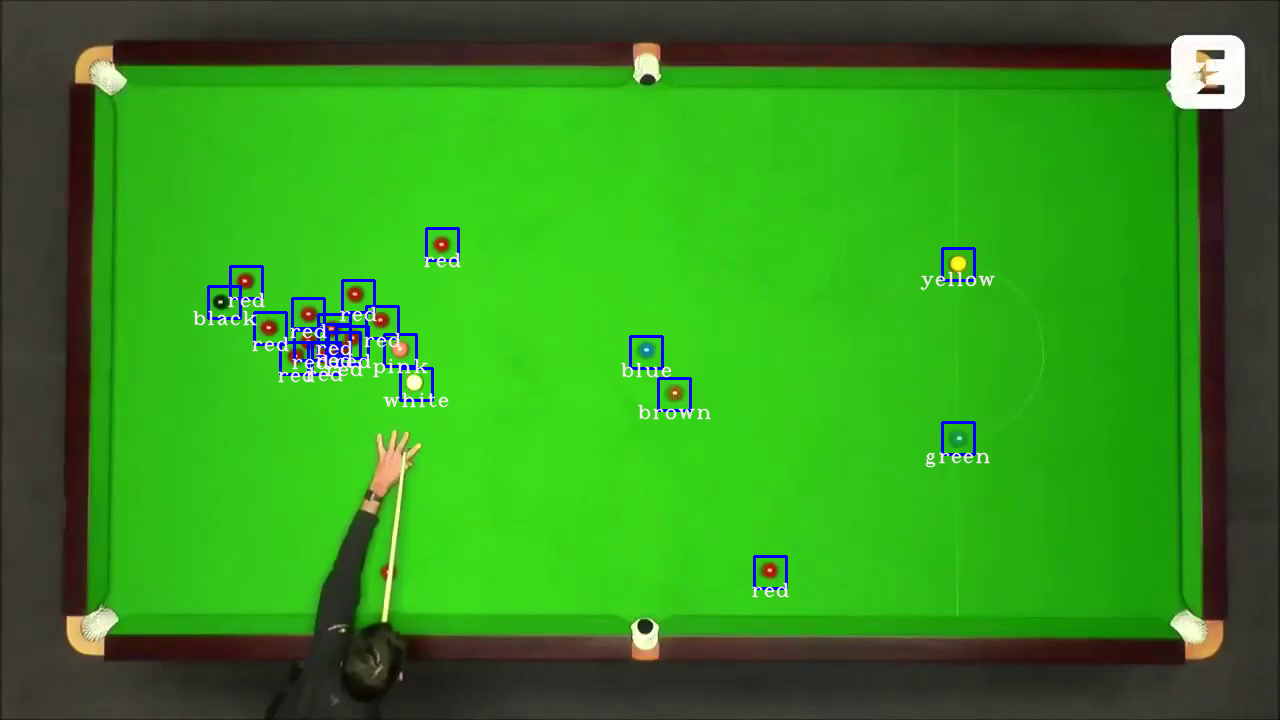